Enter event name: Nepal 5.3 2020-09-15 23:34:03
Enter event time (no data before 2010-04-14): 2020-09-15 23:34:03
Enter event depth: 10
Enter event latitude: 27.871
Enter event longitude: 85.888
Event time:  2020-09-15T23:34:03.000000Z
Coordinates of event:  27.871 85.888
Event distance (in km) from Wetterm, Germany:  6516.5
retrieving waveforms...
done


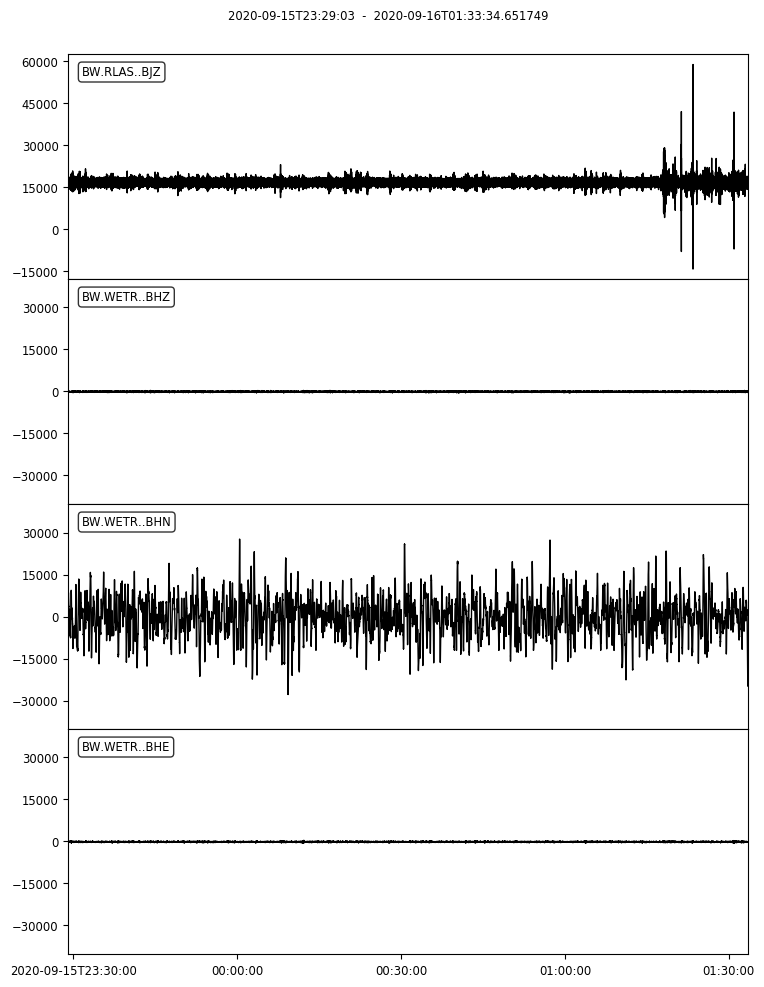

unrotated 4C plot done
traces detrended
traces filtered


C:\Users\akash\anaconda3\lib\site-packages\obspy\core\inventory\response.py:1193: UserWarning: The unit 'RAD/S' is not known to ObsPy. It will be assumed to be displacement for the calculations. This mostly does the right thing but please proceed with caution.
  warnings.warn(msg)


instrument response removed for velocities
Plots without instrument response correction


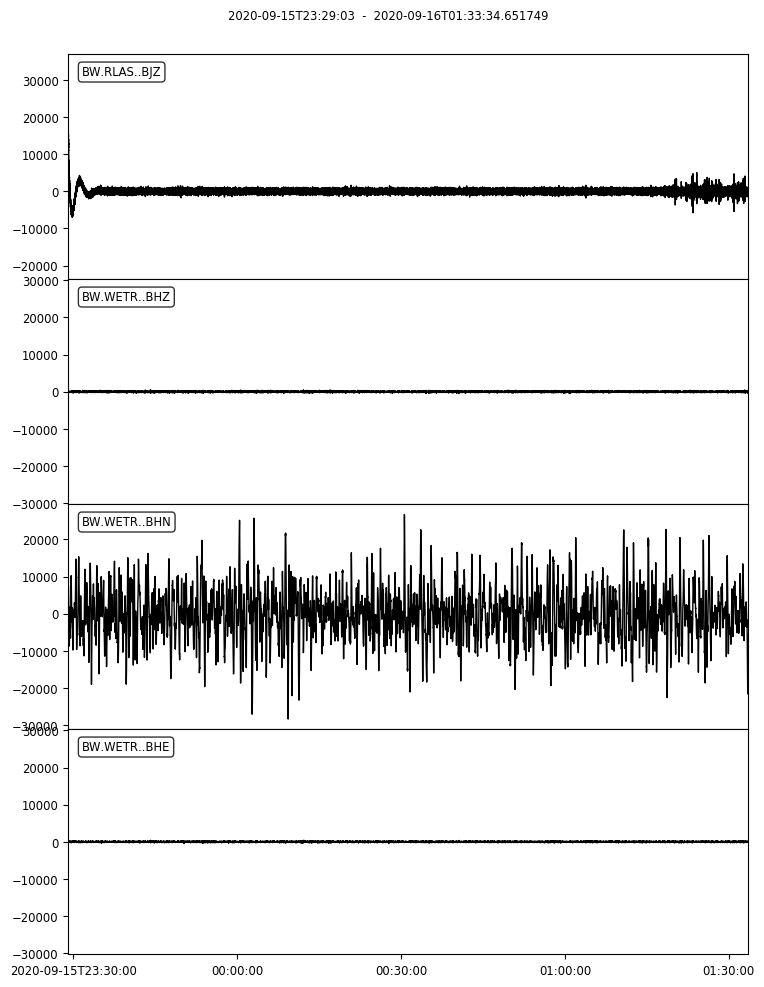

Plots after instrument response correction


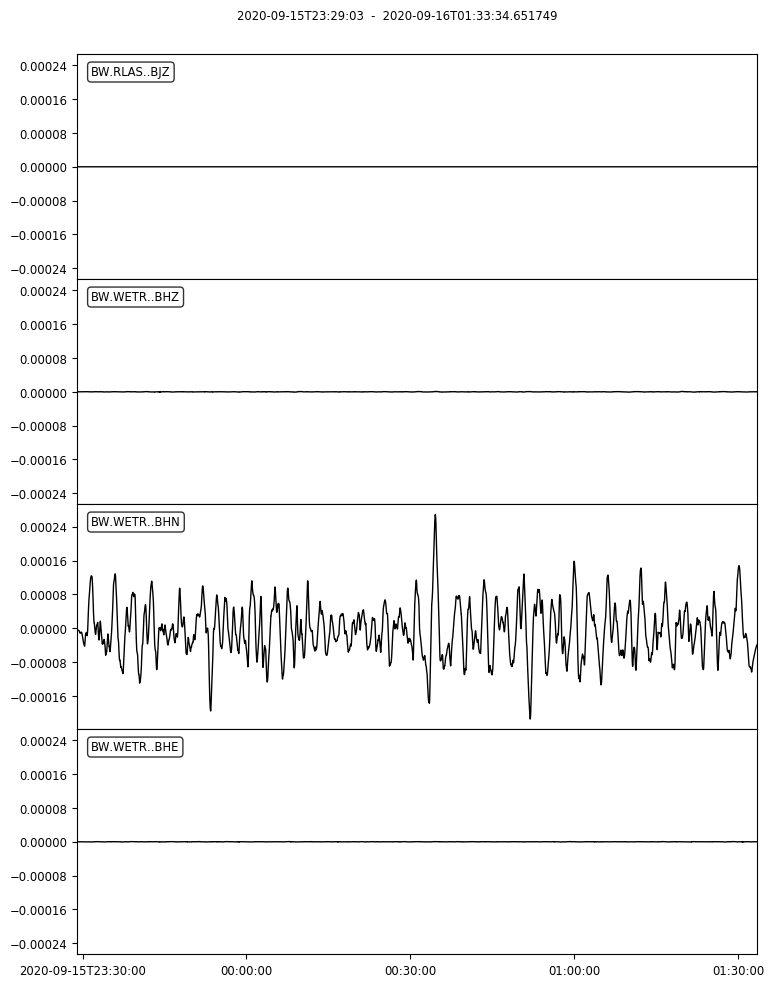

rotating the components


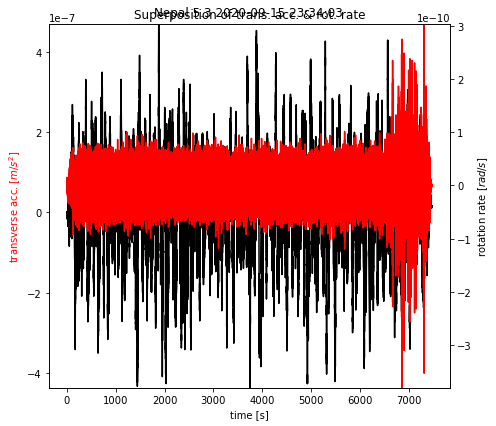

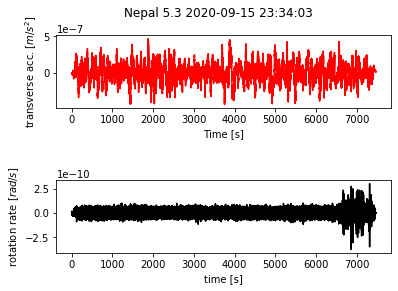

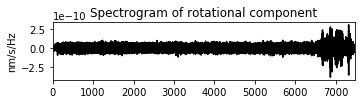

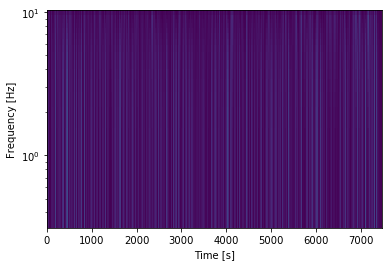

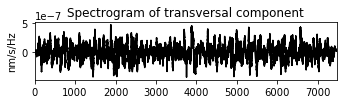

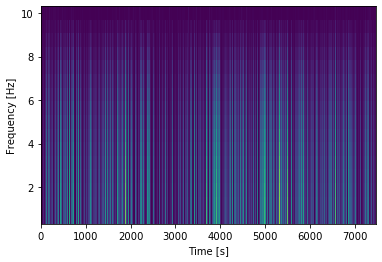

Max correlation coefficient:  [ -2.29922966e-08  -2.61479366e-07  -2.35128870e-07   3.94128785e-07
   8.11181096e-07   5.81991906e-07   2.93810036e-07  -1.02026647e-07
  -5.43927403e-07  -2.32274078e-07   2.23590184e-06   3.90318952e-06
   6.50653361e-06   3.29093451e-06  -5.12402889e-06  -8.39724977e-06
  -3.32186614e-07   8.90678860e-06   3.17669088e-06  -3.03218114e-06
   7.17375201e-06]
trans_acc_rot_rat_vs_cc_norm plot done
spectrogram plot of TA ...


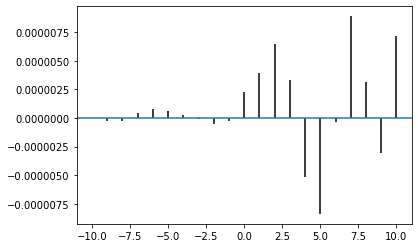

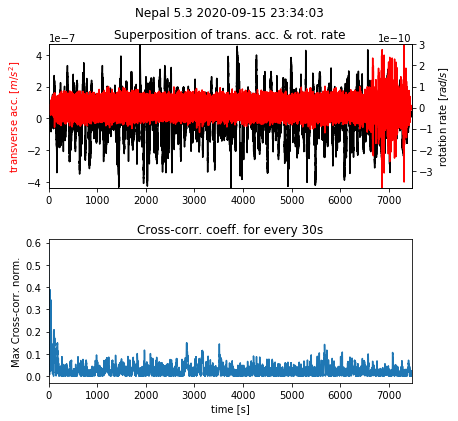

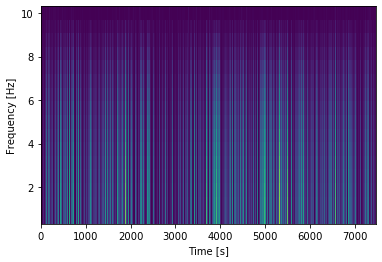

spectrogram plot done
spectrogram plot of RR ...


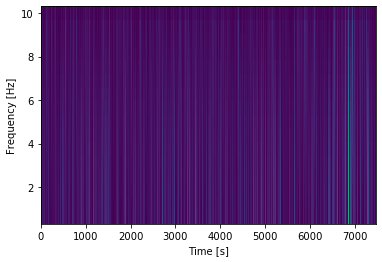

spectrogram plots done


In [12]:
import scipy
import obspy                                   #importing the necessities
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.spectrogram import spectrogram
event = input("Enter event name: ")
UTCTime = UTCDateTime(input("Enter event time (no data before 2010-04-14): ").strip())  #strip() for stripping the spaces before and after our answer
depth = float(input("Enter event depth: "))
lat2 = float(input("Enter event latitude: "))
if lat2 > 90 or lat2 < -90:            
    msg = "Latitude out of bounds! (-90 <= lat2 <=90)"
    raise ValueError(msg)
lon2 = float(input("Enter event longitude: "))   #also longitude ranges from -180 to 180
print ("Event time: " , UTCTime)
print ("Coordinates of event: " , lat2, lon2)
ba = obspy.geodetics.base.gps2dist_azimuth(49.144, 12.878, lat2, lon2) #it outputs 3 values
# distance in meteres, backazimuth angle = angle measured from north direction in a clockwise manner to the line joining station and event

ba = list(ba)
ba[1]=ba[2]+180
if ba[1]>360:
   ba[1]=ba[1]-360
ba=tuple(ba)

dist = float(ba[0]*1e-3)  # extracting the epicentral distance in Km
print("Event distance (in km) from Wetterm, Germany: ", round(dist, 1))
client = Client('LMU')
t=UTCTime
twin=(3260*2)+dist/10   #time window to extract the trace
print("retrieving waveforms...")
bhn = client.get_waveforms("BW", "WETR", "", "BHN", t - 300, t + twin)
bhe = client.get_waveforms("BW", "WETR", "", "BHE", t - 300, t + twin)
bhz = client.get_waveforms("BW", "WETR", "", "BHZ", t - 300, t + twin)
bjz = client.get_waveforms("BW", "RLAS", "", "BJZ", t - 300, t + twin)
print('done')
fc = bhn + bhe + bhz + bjz
fc.plot()
print("unrotated 4C plot done")
bhn[0].data = bhn[0].data - bhn[0].data.mean()
bhe[0].data = bhe[0].data - bhe[0].data.mean()
bhz[0].data = bhz[0].data - bhz[0].data.mean()
bhz[0].data = bhz[0].data - bhz[0].data.mean()
print("traces detrended")
resbhn = bhn[0].filter("bandpass", freqmin=0.005,freqmax= 5, corners=4)
resbhe = bhe[0].filter("bandpass", freqmin=0.005, freqmax=5, corners=4)
resbhz = bhz[0].filter("bandpass", freqmin= 0.005, freqmax=5, corners=4)
resbjz = bjz[0].filter("bandpass", freqmin= 0.005, freqmax=5, corners=4)
print("traces filtered")
inv = client.get_stations(network="BW",station="WETR",location="",channel="BH*",starttime=t-300,endtime=t+twin,level="response")
inv1 = client.get_stations(network="BW",station="RLAS",location="",channel="BJZ",starttime=t-300,endtime=t+twin,level="response")
resbhn1 = resbhn.copy().remove_response(inventory=inv, output="VEL")
resbhz1 = resbhz.copy().remove_response(inventory=inv, output="VEL")
resbhe1 = resbhe.copy().remove_response(inventory=inv, output="VEL")
resbjz1 = resbjz.copy().remove_response(inventory=inv1, output="VEL")
print("instrument response removed for velocities")
print("Plots without instrument response correction")
fs = obspy.core.Stream(resbhz)+obspy.core.Stream(resbhn)+obspy.core.Stream(resbhe)+obspy.core.Stream(resbjz)
fs.plot()
print("Plots after instrument response correction")
fr = obspy.core.Stream(resbhz1)+obspy.core.Stream(resbhn1)+obspy.core.Stream(resbhe1)+obspy.core.Stream(resbjz1)
fr.plot()
from obspy.signal.rotate import rotate_ne_rt
print("rotating the components")
rot=rotate_ne_rt(np.array(resbhn1),np.array(resbhe1),ba[1])
ta=np.diff(rot[1],n=1,axis=-1)
secbjz = np.arange(len(resbjz1))/bjz[0].stats.sampling_rate
secta = np.arange(len(ta))/20   #for obtaining frequency values
#superposition plot of rot. rate & trans. acc.
fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(111)
ax1.plot(secta, ta, 'k')
ax1.set_ylim(ymin=min(ta),ymax=max(ta))
ax1.set_title('Superposition of trans. acc. & rot. rate')
ax1.set_ylabel('transverse acc. [$m/s^2$]', color='red')
ax1.set_xlabel('time [s]')
ax2 = ax1.twinx()
ax2.plot(secbjz, resbjz1, 'r')
ax2.set_ylim(ymin=min(resbjz1),ymax=max(resbjz1))
ax2.set_ylabel('rotation rate [$rad/s$]')
ax2.set_xlabel('time [s]')
plt.suptitle('%s' % (event))
plt.savefig('superposition_TA_RR.ps')
plt.figure()
fig.tight_layout()
plt.subplot(211)
plt.plot(secta, ta, 'r')
plt.ylabel("transverse acc. [$m/s^2$]")
plt.xlabel("Time [s]")
plt.subplot(212)
plt.plot(secbjz, resbjz1, 'k')
plt.xlabel("time [s]")
plt.ylabel("rotation rate [$rad/s$]")
plt.suptitle('%s' % (event))
plt.savefig('vs_TA_RR.ps')
plt.subplots_adjust(hspace=1)
plt.show
#Spectrogram of rot. rate
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax1.plot(secbjz, np.array(resbjz1), 'k')
ax1.set_title('Spectrogram of rotational component')
ax1.set_ylabel('nm/s/Hz')
ax1.set_xlim(secbjz[0], secbjz[-1])
spectrogram(np.array(resbjz1), 20, mult=8.0, log=True)
ax2 = fig.add_axes([0.83,0.1,0.03,0.6])
ax2.set_xlabel('Sqrt')
plt.show()
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax1.plot(secta, ta,'k')
ax1.set_title('Spectrogram of transversal component')
ax1.set_ylabel('nm/s/Hz')
ax1.set_xlim(secta[0], secta[-1])
spectrogram(ta, 20, mult=8.0, log= False)
ax2 = fig.add_axes([0.83,0.1,0.03,0.6])
ax2.set_xlabel('Sqrt')
ta1= np.append(ta,1)
len(ta1)
secta1=np.append(secta,1)
len(secta1)

if len(ta1) != len(resbjz1):
   ta1=ta
#cross correlation coefficent of rot. rate & trans. acc.
a, b, c, d = plt.xcorr(ta1, resbjz1)
print('Max correlation coefficient: ' , b)
#Resizing ndarray resbjz to correlate against ta
xresbjz = resbjz1.copy()
#cross correlation along time axis
#discrete, linear correlation of two 1-dim sequences
i=0
k=0
shiftlen = 20
winlen = 30*20 #samples weil direkt auf array (30s * 20Hz)
xcorr_array = np.empty(int(len(ta)/shiftlen))
while True:
    if  i + shiftlen > len(xresbjz):
        break
    window1 = xresbjz[i : i + winlen]
    window2 = ta1[i : i + winlen]
    xcorr_array[k] = np.corrcoef(window1,window2)[1,0]
    k=k+1
    i=i + shiftlen
#setting new y range for plot
xsecbjz = np.arange(len(xresbjz))/20
#plotting the figure
fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(211)
ax1.plot(secta, ta, 'k')
ax1.set_ylim(ymin=min(ta),ymax=max(ta))
ax1.set_title('Superposition of trans. acc. & rot. rate')
ax1.set_ylabel('transverse acc. [$m/s^2$]', color='red')
ax2 = ax1.twinx()
ax2.plot(xsecbjz, xresbjz, 'r')
ax2.set_ylim(ymin=min(xresbjz),ymax=max(xresbjz))
ax2.set_ylabel('rotation rate [$rad/s$]')
ax2.set_xlabel('time [s]')
ax3 = fig.add_subplot(212, sharex=ax1)
fig.tight_layout(pad=3.0)
ax3.plot(abs(xcorr_array))
ax3.set_title('Cross-corr. coeff. for every 30s')
ax3.set_ylabel('Max Cross-corr. norm.')
ax3.set_xlabel('time [s]')
ax3.set_xlim((0,len(xcorr_array)))
plt.suptitle('%s' % (event))
plt.savefig('crosscorr_ta-rr.ps')
print("trans_acc_rot_rat_vs_cc_norm plot done")
print("spectrogram plot of TA ...")
spectrogram(ta, 20, log=False, mult=8.0)
print("spectrogram plot done")
print("spectrogram plot of RR ...")
spectrogram(np.array(xresbjz), 20, log=False, mult=8.0)
print("spectrogram plots done")